In [31]:
#importing all the important library or module which is used in this project
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

In [32]:
#loading the fashion amnist dataset
data = pd.read_csv('fmnist_small.csv')
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [33]:
#if i want to see the target variable counts
data.label.value_counts()  #this case come under the multi classifier category

label
6    656
7    620
5    612
2    604
4    595
0    595
3    591
1    590
8    582
9    555
Name: count, dtype: int64

In [34]:
#splitting the data into train tets split
from sklearn.model_selection import train_test_split

x = data.drop("label",axis=1)
y = data['label']

In [35]:
#checking gpu avilable in system or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [36]:
#now splitting them into training and testing set
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [37]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape,x_train.ndim,x_test.ndim,y_train.ndim,y_test.ndim

((4800, 784), (1200, 784), (4800,), (1200,), 2, 2, 1, 1)

In [38]:
x_train.pixel1.min(),x_train.pixel1.max()

(np.int64(0), np.int64(0))

In [39]:
#now doing input scaling and applying min max scaling to inputs
x_train = x_train/255.0
x_test  = x_test/255.0

In [40]:
type(x_train),x_train.iloc[0].dtype

(pandas.core.frame.DataFrame, dtype('float64'))

In [41]:
#changing training and testing dataset to numpy array object
x_train_np = np.array(x_train)
x_test_np =  np.array(x_test)
y_train_np = np.array(y_train)
y_test_np =  np.array(y_test)

In [42]:
x_train_np.ndim,x_train_np.dtype,x_test_np.ndim,x_test_np.dtype,y_train_np.ndim,y_train_np.dtype,y_test_np.ndim,y_test_np.dtype

(2,
 dtype('float64'),
 2,
 dtype('float64'),
 1,
 dtype('int64'),
 1,
 dtype('int64'))

# in case of multi classifier pblm statement inputs tensor dtype will be float32 and output varibale will be long

In [43]:
#now converting pandas input and output df objects  to tensor object
x_train_tensor = torch.tensor(x_train_np,dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_np,dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np,dtype=torch.long)
y_test_tensor = torch.tensor(y_test_np,dtype=torch.long)

In [44]:
x_train_tensor.dtype,x_test_tensor.dtype,y_train_tensor.dtype,y_test_tensor.dtype

(torch.float32, torch.float32, torch.int64, torch.int64)

# using dataset class i am creating custom class that split data into batch size

In [45]:
class CustomDataset(Dataset):
    #creating constructor method in that we r initializing the instance variable in it.
    def __init__(self,input_data,output_data):
        #calling parent class property
        super().__init__()
        self.input_data = input_data
        self.output_data = output_data
        
        
    #using another magical method which show the shape of input data
    def __len__(self):
        return len(self.input_data)
    
    #using another magical method which divide data into batches based on index
    def __getitem__(self, index):
        return self.input_data[index],self.output_data[index]

In [46]:
#now calling the customdatset class
training_dataset = CustomDataset(x_train_tensor,y_train_tensor)
testing_dataset  = CustomDataset(x_test_tensor,y_test_tensor)

# now using dataloader class to convert dataset into batches

In [47]:
train_dataloader_set = DataLoader(training_dataset,batch_size=8,shuffle=True,pin_memory=True)
test_dataloader_set = DataLoader(testing_dataset,batch_size=8,shuffle=True,pin_memory=True)

In [48]:
for feature,label in train_dataloader_set:
    print(feature)
    print(label)
    break

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.3608, 0.3529, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1451, 0.1333, 0.0039]])
tensor([7, 5, 3, 8, 7, 1, 4, 9])


In [49]:
x_train_tensor.shape

torch.Size([4800, 784])

In [50]:
data.label.nunique()

10

# defining the Neural network fully connected layer

In [51]:
from torch.nn import Sequential

class MyNeuralNetworkLayer(nn.Module):
    
    #using constructor method for defining the architecture of neural network !!!
    def __init__(self,input_feature_shape):
        #calling the parent class constructor inheriting the property from it.
        super().__init__()
        
        self.model = Sequential(
            
            #defining the 1st hidden layer neurons
            nn.Linear(input_feature_shape,512), #index=0
            nn.BatchNorm1d(512),                #index=1
            nn.ReLU(),
            nn.Dropout(0.3),
            
            
            #efining the 2nd hidden layer neurons
            nn.Linear(512,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            #defining the 3rd hidden layer neurons
            nn.Linear(256,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            #defining the output layer
            nn.Linear(64,10)
            #NOTE: No Softmax here → CrossEntropyLoss expects raw logits(value automatically they find probability of each class)
         
        )
    
    #creating another method to excute propogation class
    def forward(self,input_feature):
        return self.model(input_feature)

In [52]:
#creating an object of custom neural network class
inp_shape = x_train_tensor.shape[1]
model = MyNeuralNetworkLayer(inp_shape).to(device=device)
model

MyNeuralNetworkLayer(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [53]:
#if i wan tto show how many no of trainable parameter trained by model
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
MyNeuralNetworkLayer                     --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       401,920
│    └─BatchNorm1d: 2-2                  1,024
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       131,328
│    └─BatchNorm1d: 2-6                  512
│    └─ReLU: 2-7                         --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       16,448
│    └─BatchNorm1d: 2-10                 128
│    └─ReLU: 2-11                        --
│    └─Dropout: 2-12                     --
│    └─Linear: 2-13                      650
Total params: 552,010
Trainable params: 552,010
Non-trainable params: 0

In [54]:
#now defining how many no of iteration want to give at time of training,what will be loss function,optimers

loss_fxn = nn.CrossEntropyLoss() #this loss fxn will be same as sparse categorical cross entropy
optimizers = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0.01) 
#optimizer we used to update the trainable paramerter in each layer during Back Propgation time
epochs=10

In [55]:
optimizers

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)

In [56]:
print("First Hidden Layer Weights (Before Training):")
print(model.model[0].weight)

First Hidden Layer Weights (Before Training):
Parameter containing:
tensor([[-0.0322, -0.0321,  0.0275,  ..., -0.0088, -0.0137, -0.0023],
        [ 0.0141, -0.0279, -0.0049,  ..., -0.0106, -0.0333, -0.0009],
        [-0.0275, -0.0249,  0.0027,  ..., -0.0016,  0.0085,  0.0260],
        ...,
        [ 0.0305, -0.0152,  0.0227,  ..., -0.0158, -0.0041, -0.0143],
        [ 0.0288, -0.0028, -0.0180,  ..., -0.0218,  0.0216,  0.0021],
        [ 0.0315, -0.0085,  0.0047,  ..., -0.0198, -0.0295,  0.0012]],
       device='cuda:0', requires_grad=True)


In [57]:
print("First Hidden Layer Bias (Before Training):")
print(model.model[0].bias)

First Hidden Layer Bias (Before Training):
Parameter containing:
tensor([-0.0094, -0.0140,  0.0269,  0.0340, -0.0115, -0.0143,  0.0089, -0.0280,
         0.0183,  0.0002,  0.0058,  0.0313,  0.0071, -0.0030,  0.0085, -0.0342,
         0.0265,  0.0126, -0.0159,  0.0100, -0.0267,  0.0193,  0.0048, -0.0337,
        -0.0189,  0.0018, -0.0073,  0.0010, -0.0233, -0.0306, -0.0279,  0.0214,
         0.0231, -0.0180, -0.0317, -0.0169, -0.0083,  0.0113, -0.0042, -0.0167,
         0.0244,  0.0057, -0.0350, -0.0189, -0.0321, -0.0003, -0.0124,  0.0139,
         0.0310,  0.0248, -0.0247,  0.0291,  0.0202, -0.0050,  0.0024, -0.0061,
        -0.0109,  0.0125, -0.0285,  0.0313, -0.0163,  0.0016, -0.0272,  0.0236,
        -0.0107,  0.0082, -0.0287, -0.0250, -0.0336,  0.0168, -0.0320, -0.0032,
        -0.0036,  0.0155, -0.0212, -0.0288, -0.0342,  0.0096,  0.0354, -0.0056,
        -0.0262, -0.0302,  0.0061,  0.0124,  0.0172, -0.0159, -0.0350, -0.0172,
         0.0311,  0.0059,  0.0106,  0.0104,  0.0017, -0

In [58]:
print("Second Hidden Layer Weights (Before Training):")
print(model.model[4].weight)

Second Hidden Layer Weights (Before Training):
Parameter containing:
tensor([[ 0.0143,  0.0048, -0.0227,  ...,  0.0366, -0.0319, -0.0414],
        [ 0.0214, -0.0232, -0.0153,  ..., -0.0199,  0.0111, -0.0068],
        [ 0.0368, -0.0386, -0.0036,  ..., -0.0159,  0.0251, -0.0044],
        ...,
        [-0.0310,  0.0065, -0.0295,  ..., -0.0144, -0.0046,  0.0434],
        [ 0.0272, -0.0030,  0.0352,  ..., -0.0073, -0.0408,  0.0396],
        [ 0.0242, -0.0428,  0.0340,  ..., -0.0009,  0.0297,  0.0386]],
       device='cuda:0', requires_grad=True)


# now we will start the training of model

In [59]:
avg_training_loss,avg_testing_loss = [],[]
for epoch in range(epochs):
    model.train()
    
    training_loss_count = 0  # <- Reset for each epoch
    
    #first we load tha dataset and passing them into neural architecture 
    for train_feature,train_label in train_dataloader_set:
        #now laoding the data into GPU
        train_feature = train_feature.to(device)
        train_label   = train_label.to(device)
        
        #now passing the training feature to neural netowrk architecture the first algorithm that work is forward pass.
        #generate the prediction output
        y_prediction = model.forward(train_feature)
        
        #evaluating the performance of model at time of training by calculating the loss value.
        losses = loss_fxn(y_prediction,train_label)
        
        #updating the training_loss_count
        training_loss_count = training_loss_count+losses.item()
        
        #clearing the gradient in optimizers object
        optimizers.zero_grad() #before reducing the loss value by using backpropgation algorithm first of we have to clear the gradients which present in optimizers
        
        #now reducing the loss value by doing back propgation algorithm
        losses.backward() #back propgation algorithm will calculate the gradients in each layer of trainaianble parameter wrt to losses
        
        #updating the trainable parameter by using optimizers
        optimizers.step()
    
    #now calculating average training loss.
    avg_train_loss = training_loss_count/len(train_dataloader_set)
    avg_training_loss.append(avg_train_loss)
    
    
    
    #now validating the testing loss or testing data.
    testing_loss_count = 0
    
    model.eval()
    
    #while testing the data we have to stop trcking the require gradient not applying overfitting and backpropogation in it.
    with torch.no_grad():
        for test_feature,test_label in test_dataloader_set:
            #now loading the data into GPU
            test_feature = test_feature.to(device)
            test_label   = test_label.to(device)
            
            #now passing the test feature into neural network architecture and doing forward pass calculation.
            prediction = model.forward(test_feature) #return each batch ke andar each record ke 10 probability
            
            #calculating the testing loss and updating the testing_loss_count
            test_loss = loss_fxn(prediction,test_label)
            
            testing_loss_count = testing_loss_count+test_loss.item()
    
        #now calculating average training loss.
        avg_test_loss = testing_loss_count/len(test_dataloader_set)
        avg_testing_loss.append(avg_test_loss)
        
        
        
        print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}")
           

Epoch [1/10], Train Loss: 1.6299, Test Loss: 1.1809
Epoch [2/10], Train Loss: 1.2177, Test Loss: 0.9612
Epoch [3/10], Train Loss: 1.0627, Test Loss: 0.8029
Epoch [4/10], Train Loss: 0.9657, Test Loss: 0.7396
Epoch [5/10], Train Loss: 0.8708, Test Loss: 0.6383
Epoch [6/10], Train Loss: 0.8160, Test Loss: 0.6456
Epoch [7/10], Train Loss: 0.7915, Test Loss: 0.5991
Epoch [8/10], Train Loss: 0.7559, Test Loss: 0.5836
Epoch [9/10], Train Loss: 0.7140, Test Loss: 0.5616
Epoch [10/10], Train Loss: 0.7115, Test Loss: 0.5575


# to track train accuracy and test accuracy while training and evaluating the model

In [60]:
avg_training_loss, avg_testing_loss = [], []
training_accuracies, testing_accuracies = [], []

for epoch in range(epochs):
    # ---- TRAINING ----
    model.train()
    training_loss_count = 0
    correct_train = 0
    total_train = 0
    
    for train_feature, train_label in train_dataloader_set:
        train_feature = train_feature.to(device)
        train_label   = train_label.to(device)
        
        # Forward pass
        y_prediction = model(train_feature)
        
        # Loss
        losses = loss_fxn(y_prediction, train_label)
        training_loss_count += losses.item()
        
        # Accuracy calculation (for multiclass)
        _, predicted = torch.max(y_prediction, 1)  #_, predicted = torch.max(output, 1) → highest probability class index nikalta hai.
        correct_train += (predicted == train_label).sum().item()
        total_train   += train_label.size(0)
        
        # Backpropagation
        optimizers.zero_grad()
        losses.backward()
        optimizers.step()
    
    avg_train_loss = training_loss_count / len(train_dataloader_set)
    train_accuracy = (correct_train / total_train) * 100 #accuracy training calculation
    avg_training_loss.append(avg_train_loss)
    training_accuracies.append(train_accuracy)
    
    # ---- TESTING ----
    model.eval()
    testing_loss_count = 0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for test_feature, test_label in test_dataloader_set:
            test_feature = test_feature.to(device)
            test_label   = test_label.to(device)
            
            prediction = model(test_feature)
            test_loss = loss_fxn(prediction, test_label)
            testing_loss_count += test_loss.item()
            
            # Accuracy calculation
            _, predicted = torch.max(prediction, 1)
            correct_test += (predicted == test_label).sum().item()
            total_test   += test_label.size(0)
    
    avg_test_loss = testing_loss_count / len(test_dataloader_set)
    test_accuracy = (correct_test / total_test) * 100
    avg_testing_loss.append(avg_test_loss)
    testing_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% "
          f"| Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


Epoch [1/10], Train Loss: 0.6876, Train Acc: 79.17% | Test Loss: 0.5536, Test Acc: 83.25%
Epoch [2/10], Train Loss: 0.6683, Train Acc: 79.54% | Test Loss: 0.5524, Test Acc: 81.67%
Epoch [3/10], Train Loss: 0.6514, Train Acc: 79.88% | Test Loss: 0.5221, Test Acc: 84.17%
Epoch [4/10], Train Loss: 0.6348, Train Acc: 80.96% | Test Loss: 0.5321, Test Acc: 83.00%
Epoch [5/10], Train Loss: 0.6158, Train Acc: 80.79% | Test Loss: 0.5218, Test Acc: 82.92%
Epoch [6/10], Train Loss: 0.6218, Train Acc: 80.21% | Test Loss: 0.5061, Test Acc: 83.08%
Epoch [7/10], Train Loss: 0.6174, Train Acc: 80.98% | Test Loss: 0.5242, Test Acc: 83.17%
Epoch [8/10], Train Loss: 0.6084, Train Acc: 81.00% | Test Loss: 0.5349, Test Acc: 82.00%
Epoch [9/10], Train Loss: 0.5838, Train Acc: 81.71% | Test Loss: 0.5210, Test Acc: 83.42%
Epoch [10/10], Train Loss: 0.5852, Train Acc: 81.58% | Test Loss: 0.5033, Test Acc: 83.75%


# to visualize the training vs testing loss

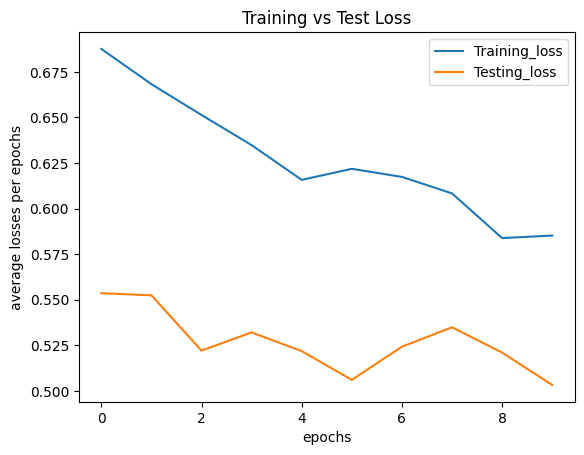

In [61]:
import matplotlib.pyplot as plt
plt.plot(avg_training_loss,label="Training_loss")
plt.plot(avg_testing_loss,label="Testing_loss")
plt.xlabel("epochs")
plt.ylabel("average losses per epochs")
plt.title('Training vs Test Loss')
plt.legend()
plt.show()

